<font color='#0000FF' size='7'>**Промежуточная аттестация № 1**</font>  
<font color='#0066CC' size='6'>**Тема: Классическое машинное обучение**</font>  

<font size='5'>**Данные :**</font>  
скачать данные `kaggle competitions download -c bike-sharing-demand`

<font size='5'>**Описание данных :**</font>  
https://www.kaggle.com/competitions/bike-sharing-demand/data

<font size='5'>**Задание:**</font>  
Аттестация основана на конкурсе https://www.kaggle.com/competitions/bike-sharing-demand/overview

В конкурсе даны данные о почасовой аренде велосипедов за два года. Обучающий набор состоит из первых 19 дней каждого месяца, а тестовый набор — с 20-го числа до конца месяца. Необходимо спрогнозировать общее количество велосипедов, взятых напрокат в течение каждого часа, охватываемого тестовым набором, используя только информацию, доступную до начала периода аренды.

Оценка решений производится с использованием корня из среднеквадратичной логарифмической ошибки (RMSLE).   
RMSLE вычисляется по формуле
$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(p_i + 1) - \log(a_i + 1) \right)^2}$$

Где:

- $ n $ — количество часов
- $ p_i $ — предсказанное количество
- $ a_i $ — фактическое количество
- $ \log(x) $ — натуральный логарифм


<img src="https://drive.google.com/uc?export=view&id=1lv9FV80T0d5iEtbuGnrS8K2BUUOqq4E-" alt="Описание изображения" width="600"/>


# <font color='#0066CC' size='6'> **Импорт и установка библиотек**

In [ ]:
from google.colab import drive
import json
import zipfile

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import shap

# <font color='#0066CC' size='6'> **Загрузка данных**

In [ ]:
def load_dataset(from_kaggle=False) -> pd.DataFrame:
  '''
  Функция скачивает данные с сайта kaggle, если установлен from_kaggle=True,
  инчае архив считывается по ссылке с моегого гугл диска (такой способ удобен тем, у кого нет доступа к kaggle)
  '''
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c bike-sharing-demand
  else:
    !gdown 1-ENvRYbjScwCDcscDllGfiT6CMvTA-E1

  # распаковка архива
  zip_ref = zipfile.ZipFile('bike-sharing-demand.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sampleSubmission.csv')
  return df_train, df_test, df_sample_submission

In [ ]:
# К сожалению, не получилось открыть данным способом
# Скачала файлы из источника

# df_train, df_test, df_sample_submission = load_dataset(from_kaggle=True)

In [ ]:
# это данные для примера, в таком виде необходимо сделать выборку и загрузить на kaggle
#  (для тех, кто хочет увидеть себя в лидерборде и оценить на сколько ваше решение лучше/хуже остальных)
# df_sample_submission.head()

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [ ]:
# это тестовые данные, для которых необходимо предсказать target, то есть применить модель,
#  которую вы разработаете на данных df_train
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
# на этих данных дальше необходимо разработать модель
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## <font color='#0066CC' size='5'> Определите роли переменных (целевая переменная, независимые переменные)

In [ ]:
target = 'count'

In [ ]:
features_num = [feature for feature in df_train.select_dtypes(include='number').columns.to_list()
               if feature not in [target]]
features_num

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered']

In [ ]:
features_datetime = [feature for feature in df_train.columns.to_list() if feature
                not in [target, *features_num]]
features_datetime

['datetime']

# <font color='#0066CC' size='6'> **Разведочный анализ данных**

## <font color='#0066CC' size='5'> Оцените размер вашего датасета


1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [ ]:
import sys

memory_usage_gb = df_train.memory_usage(deep=True).sum() / (1024 * 1024 * 1024)  # размер в ГБ
print(f"Размер DataFrame в памяти: {memory_usage_gb:.6f} ГБ")

Размер DataFrame в памяти: 0.001663 ГБ


In [ ]:
num_rows, num_columns = df_train.shape

print(f"Количество строк: {num_rows}")
print(f"Количество столбцов: {num_columns}")

Количество строк: 10886
Количество столбцов: 12


## <font color='#0066CC' size='5'> Анализ категориальных признаков


In [ ]:
for column in df_train.select_dtypes(include=['object', 'category']):
    print(f"{column}: {df_train[column].nunique()} уникальных значений")

datetime: 10886 уникальных значений


In [ ]:
for column in df_train.select_dtypes(include=['object', 'category']):
    print(df_train[column].value_counts())

datetime
2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: count, Length: 10886, dtype: int64


Если данные уникальны (в нашем случае каждая дата уникальна) и не имеют значимого значения для нашей модели или анализа, их можно убрать из итогового набора данных.

## <font color='#0066CC' size='5'> Анализ пропусков


In [ ]:
missing_values = df_train.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


## <font color='#0066CC' size='5'> Анализ выбросов


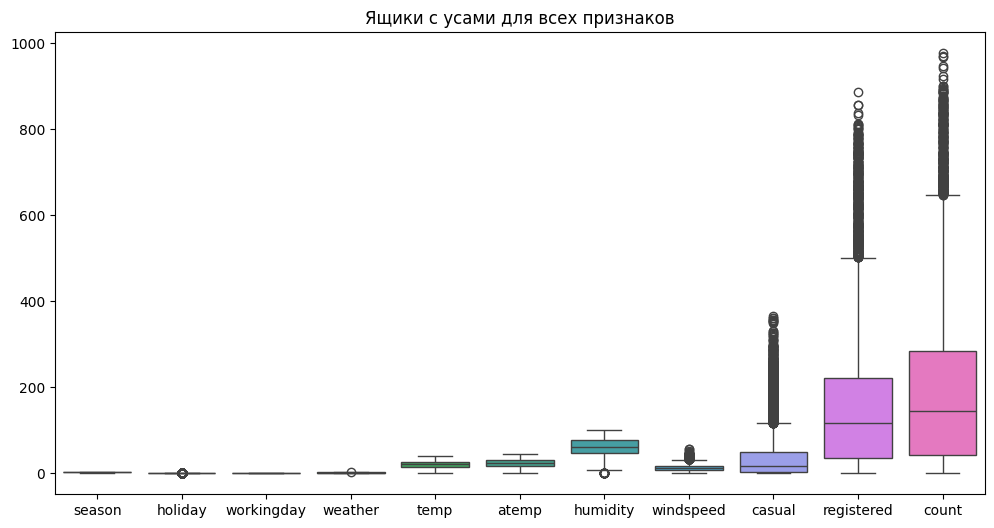

In [ ]:
# Визуализация выбросов с помощью ящика с усами
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train)
plt.title('Ящики с усами для всех признаков')
plt.show()

In [ ]:
# Рассчитаем межквартильный размах (IQR) для каждого признака
Q1 = df_train[features_num + [target]].quantile(0.25)
Q3 = df_train[features_num + [target]].quantile(0.75)
IQR = Q3 - Q1

# Определяем выбросы
is_outlier = (df_train[features_num + [target]] < (Q1 - 1.5 * IQR)) | (df_train[features_num + [target]] > (Q3 + 1.5 * IQR))
print("Выбросы:")
print(df_train[features_num + [target]][is_outlier.any(axis=1)])

Выбросы:
       season  holiday  workingday  weather   temp   atemp  humidity  \
175         1        0           0        1   8.20   8.335        32   
178         1        0           0        1   6.56   6.060        37   
194         1        0           0        1   4.92   3.790        46   
196         1        0           0        1   6.56   6.060        40   
265         1        0           1        1   8.20   7.575        47   
...       ...      ...         ...      ...    ...     ...       ...   
10855       4        0           1        1  16.40  20.455        47   
10856       4        0           1        1  15.58  19.695        46   
10870       4        0           1        1   9.84  12.880        87   
10879       4        0           1        1  16.40  20.455        50   
10880       4        0           1        1  15.58  19.695        50   

       windspeed  casual  registered  count  
175      32.9975      12          83     95  
178      36.9974       5          

In [ ]:
# Удаляем строки с любым выбросом
cleaned_data = df_train[features_num + [target]][~is_outlier.any(axis=1)]

print(f"Размер данных до удаления выбросов: {df_train[features_num + [target]].shape[0]}")
print(f"Размер данных после удаления выбросов: {cleaned_data.shape[0]}")

Размер данных до удаления выбросов: 10886
Размер данных после удаления выбросов: 9263


In [ ]:
cleaned_data.reset_index(drop=True, inplace=True)

In [ ]:
cleaned_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# <font color='#0066CC' size='6'> **Разделите данные на тренировочную и тестовые выборки**

In [ ]:
# Целевая переменная и признаки
X = cleaned_data.drop('count', axis=1)
y = cleaned_data['count']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# <font color='#0066CC' size='6'> **Подготовка данных к обучению**



1.   Обработка категориальных переменных
2.   Обработка пропусков
3.   Нормализация данных
4.   Обработка выбросов (если в данных есть выбросы)



In [ ]:
# Если в данных есть пропуски, используйте SimpleImputer для их обработки.
# В нашем примере пропусков нет, но вот как это сделать, если они появятся:
from sklearn.impute import SimpleImputer

# Инициализация и применение SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [ ]:
# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Инициализация и применение StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# <font color='#0066CC' size='6'> **Построение моделей**

## <font color='#0066CC'> Методы обучения без учителя (Unsupervised learning)

<font color='#0066CC'> Постройте модель кластеризации, исключив предварительно из данных целевой признак. Далее оцените качество кластеризации с помощью метрик без целевого признака и с помощью метрик на основании целевого признака

In [ ]:
# Построение модели KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)

# Прогнозирование кластеров на тестовых данных
clusters_test = kmeans.predict(X_test_scaled)

# Оценка качества кластеризации
# Для тестовых данных используем Silhouette Score и Davies-Bouldin Index
silhouette_avg_test = silhouette_score(X_test_scaled, clusters_test)
davies_bouldin_test = davies_bouldin_score(X_test_scaled, clusters_test)

print(f"Silhouette Score for Test Data: {silhouette_avg_test:.4f}")
print(f"Davies-Bouldin Index for Test Data: {davies_bouldin_test:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Test Data: 0.1926
Davies-Bouldin Index for Test Data: 1.7643


Значение Silhouette Score 0.1926 указывает на то, что качество кластеризации не очень высокое. Это может свидетельствовать о том, что кластеры не совсем хорошо отделены друг от друга, или что выбранное количество кластеров не является оптимальным для данных.

Значение Davies-Bouldin Index 1.7643 указывает на то, что качество кластеризации может быть низким. Это может означать, что кластеры имеют высокую внутреннюю дисперсию или слишком близко расположены друг к другу.

Среднее значение целевого признака в кластерах:
cluster
0     95.883749
1    288.300248
2     89.041593
Name: count, dtype: float64


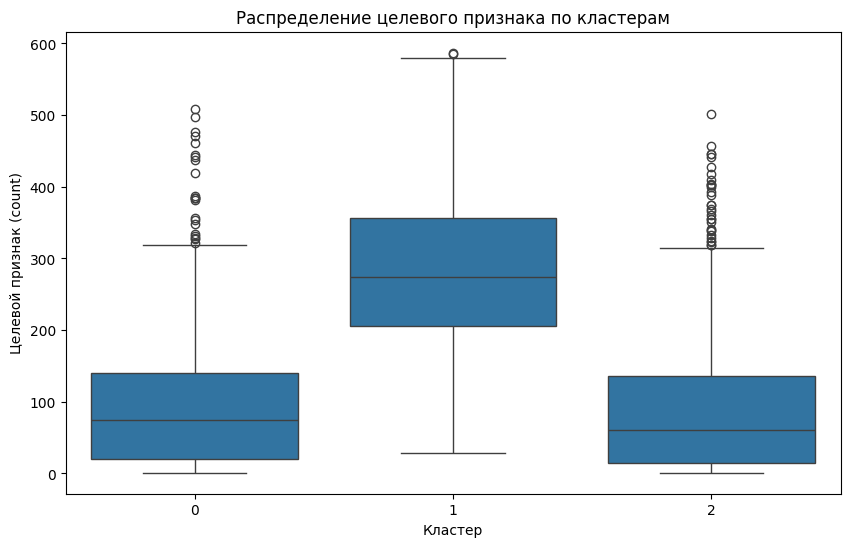

In [ ]:
# Оценка качества кластеризации (метрики с целевым признаком)
test_data = pd.DataFrame(X_test_scaled, columns=X.columns)
test_data['cluster'] = clusters_test
test_data['count'] = y_test.values

# Среднее значение целевого признака в кластерах
cluster_summary = test_data.groupby('cluster')['count'].mean()
print("Среднее значение целевого признака в кластерах:")
print(cluster_summary)

# Визуализация распределения целевого признака в кластерах
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='count', data=test_data)
plt.title('Распределение целевого признака по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Целевой признак (count)')
plt.show()

## <font color='#0066CC'> Методы обучения c учителем (Supervised learning)

<font color='#0066CC'> Постройте несколько моделей обучения с учителем:
 - knn
 - линейная регрессия
 - SVM
 - дерево решений
 - Случайный лес
 - Градиентный бустинг




In [ ]:
# Словарь для хранения моделей
models = {
    'KNN': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Словарь для хранения лучших моделей
best_models = {}

# Гиперпараметры для GridSearchCV
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

# GridSearchCV для подбора гиперпараметров
for name, model in models.items():
    print(f"Training {name}...")
    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Training KNN...
Best parameters for KNN: {'n_neighbors': 5}
Training Linear Regression...
Best parameters for Linear Regression: {}
Training SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'linear'}
Training Decision Tree...
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 5}
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


<font color='#0066CC'>  Рассчитать метрики качества, построить графики, по которым вы сможете понять качество модели

                            MSE           MAE        R2
KNN                5.363205e+02  1.722663e+01  0.968833
Linear Regression  2.576830e-26  1.287210e-13  1.000000
SVM                4.553620e-03  6.041814e-02  1.000000
Decision Tree      1.215940e+01  1.993373e+00  0.999293
Random Forest      2.921560e+00  8.734059e-01  0.999830
Gradient Boosting  2.009326e+00  8.215059e-01  0.999883


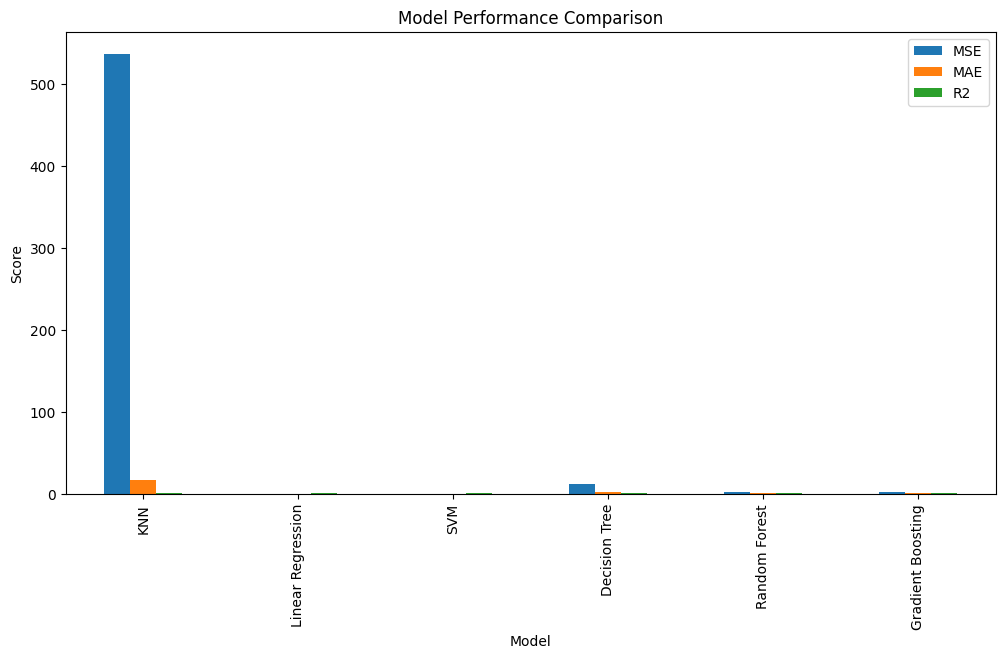

In [ ]:
# Оценка моделей
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Создание DataFrame для удобного отображения результатов
results_df = pd.DataFrame(results).T
print(results_df)

# Построение графиков метрик
results_df[['MSE', 'MAE', 'R2']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

**Линейная регрессия и SVM:**

Обе модели показывают идеальные или почти идеальные значения R² (1.00). Это указывает на то, что модели хорошо объясняют вариацию целевого признака.
Среднеквадратичная ошибка (MSE) и средняя абсолютная ошибка (MAE) для линейной регрессии и SVM очень малы, что также указывает на отличную производительность моделей.

**Случайный лес и Градиентный бустинг:**

Обе модели также показывают очень высокие значения R² (приблизительно 0.9998 и 0.9999 соответственно), что говорит о высокой точности этих моделей.
MSE и MAE для случайного леса и градиентного бустинга немного больше, чем для линейной регрессии и SVM, но все равно являются низкими, что указывает на хорошие результаты.

**KNN:**

Значения R² (0.97) для KNN ниже, чем для других моделей, что может указывать на меньшую точность по сравнению с другими моделями.
MSE и MAE для KNN также значительно выше по сравнению с другими моделями.

In [ ]:
def plot_feature_importance(model, X):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        raise ValueError("Model does not have feature importances or coefficients")

    feature_names = X.columns
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(X.shape[1]), importances[indices], align='center')
    plt.yticks(range(X.shape[1]), feature_names[indices])
    plt.xlabel('Importance')
    plt.show()

 <font color='#0066CC'>  Оцените важность переменных с помощью SHAP и permitation feature importance

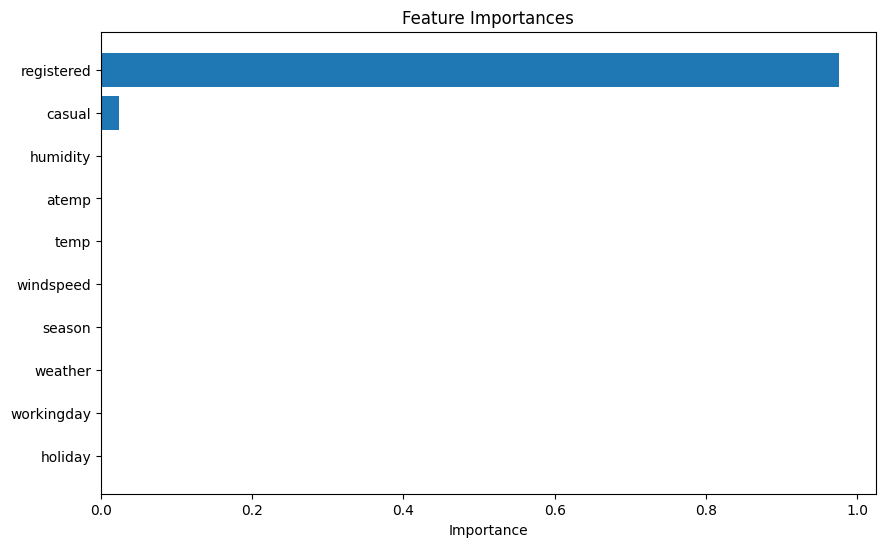

 99%|===================| 9213/9263 [01:05<00:00]       

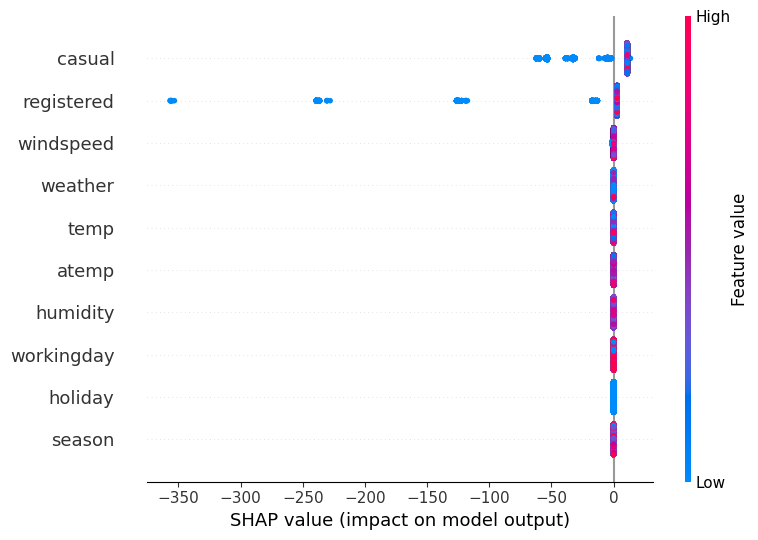

In [ ]:
def plot_shap_values(model, X, y):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X)

# Выбор модели для оценки важности переменных
selected_model = best_models['Random Forest']
plot_feature_importance(selected_model, X)

# SHAP для случайного леса
plot_shap_values(selected_model, X, y)

# <font color='#0000FF' size='6'> **Опционально, для тех, кто хочет сравнить свое решение с другими решениями на kaggle. Применение алгоритма к тестовой выборке df_test и сабмит решения на kaggle**

In [ ]:
# ваш код

In [ ]:
# # загрузка данных на kaggle (нужен доступ на kaggle)
# kaggle competitions submit -c bike-sharing-demand -f /content/submissions.csv -m "Message"